<a href="https://colab.research.google.com/github/konpatel/Pneumonia-detection-xray/blob/master/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install wandb

import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb.init(project="pneumonia-ml-masters", entity="m101-mpt")
wandb.config = {
    "learning_rate": 1e-4,
    "epochs": 100,
    "batch_size": 32
}

from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout,GlobalAveragePooling2D
from keras.models import Model,load_model,Sequential
import keras.backend as K

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras.applications.resnet import ResNet50

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)



In [3]:
traindf=pd.read_csv("/content/drive/MyDrive/MachineLearningImages/labels_train.csv",dtype=str)
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.05,
        horizontal_flip=True,
        validation_split=0.2,
        fill_mode='nearest')

In [4]:
#Διάσταση κάθε εικόνας
IMAGE_SIZE    = (224, 224)
#Αριθμός κατηγοριών που θα γίνει το classification
NUM_CLASSES   = 3
#Σύνολο εικόνων που θα τροφοδοτούμε το μοντέλο κάθε φορά
BATCH_SIZE    = 32  
#Αριθμός layer που θα αποκλείσουμε από το CNN
FREEZE_LAYERS = 2  
#Αριθμός Εποχών
NUM_EPOCHS    = 1
#Filename του μοντέλου
WEIGHTS_FINAL = 'model-final.h5'

In [5]:
train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="/content/drive/MyDrive/MachineLearningImages/train_images/",
    x_col="file_name",
    y_col="class_id",
    subset="training",
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    color_mode = 'grayscale',
    class_mode="categorical",
    target_size=IMAGE_SIZE)

valid_generator =datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="/content/drive/MyDrive/MachineLearningImages/train_images",
    x_col="file_name",
    y_col="class_id",
    subset="validation",
    interpolation='nearest',
    color_mode = 'grayscale',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)

Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.


Found 1168 images belonging to 2 classes.


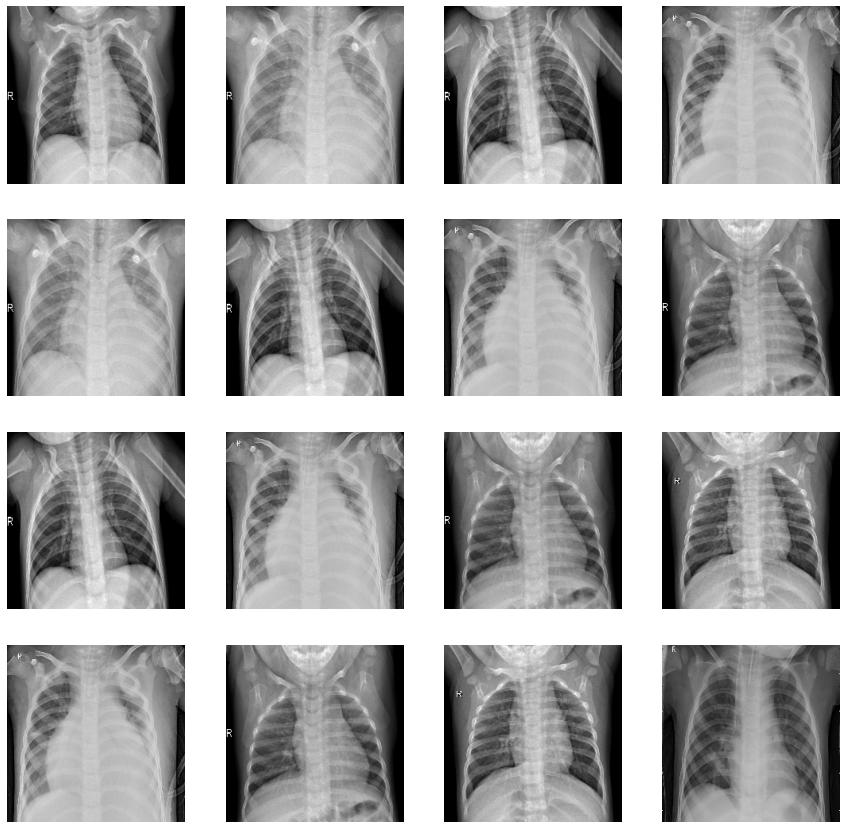

In [7]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(    
    directory="/content/drive/MyDrive/MachineLearningImages/test_images",    
    batch_size=16,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

images = test_generator.next()
for i in range(4):
    for j in range(4):
        image_new = images[i+j]
        ax[i][j].imshow(image_new, cmap='gray')
        ax[i][j].axis('off')

plt.show()

In [8]:
from tensorflow.keras.layers import Input
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation


In [ ]:
# inputs = Input(shape=(255, 255, 3))

conv_model = ResNet50(weights=None, include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = Flatten()(conv_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
full_model.summary()



# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [10]:
max_epochs = 100



full_model.fit(train_generator,
                        validation_data = valid_generator,
                        batch_size=BATCH_SIZE,
                        epochs=max_epochs,
                        callbacks=[lr_reduce,early_stop,WandbCallback(), checkpoint],             
                        verbose=1)

# save trained weights
full_model.save(WEIGHTS_FINAL)

Epoch 1/100


InvalidArgumentError: ignored